### Dask Arrays

In [1]:
import numpy as np
x = np.random.random((1000,1000))
u, s, v = np.linalg.svd(x.dot(x.T))

In [2]:
import dask.array as da
x = da.random.random((100000, 100000), chunks=(1000,1000))
u, s, v = da.linalg.svd(x.dot(x.T))

E:\Jiang\Anaconda3\lib\site-packages\dask\array\core.py:2166: UserWarning: Increasing number of chunks by factor of 100
  (nparts / max_parts))


ValueError: Input must have the following properties:
  1. Have two dimensions
  2. Have only one column of blocks

In [4]:
from dask.distributed import Client, progress
c = Client()
c

Client Scheduler: tcp://127.0.0.1:52535 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 4 Memory: 8.46 GB


In [5]:
def process(input):
    return input**2

In [8]:
results = [process(x) for x in range(0,50)]

In [9]:
from dask import compute, delayed
values = [delayed(process)(x) for x in range(0,50)]

In [10]:
import dask.threaded
results = compute(*values, get=dask.threaded.get)

In [11]:
import dask.multiprocessing
results = compute(*values, get=dask.multiprocessing.get)

In [8]:
import dask.array as da
x = da.ones((100, 100), chunks=(10, 10))

y = x + x.T
x

dask.array<wrapped, shape=(100, 100), dtype=float64, chunksize=(10, 10)>

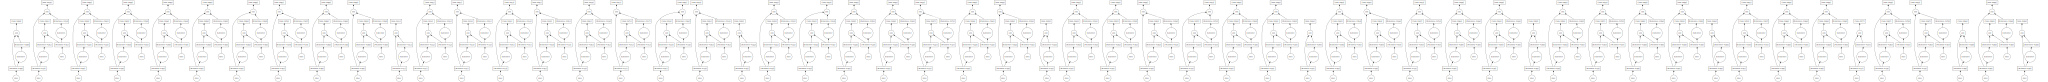

In [9]:
# y.compute()
y.visualize(filename='transpose.svg')

In [10]:
y.compute()

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]])

In [18]:
>>> from dask.diagnostics import ProgressBar, Profiler
>>> a = da.random.normal(size=(10000, 10000), chunks=(1000, 1000))
>>> res = a.dot(a.T).mean(axis=0)

>>> with Profiler():
        out = res.compute()


[                                        ] | 0% Completed |  0.0s

E:\Jiang\Anaconda3\lib\site-packages\dask\array\core.py:2166: UserWarning: Increasing number of chunks by factor of 10
  (nparts / max_parts))


[#                                       ] | 3% Completed |  2.8s


KeyboardInterrupt: 

In [21]:
>>> from operator import add, mul
>>> from dask.threaded import get
>>> dsk = {'x': 1, 'y': (add, 'x', 10), 'z': (mul, 'y', 2)}
>>> with Profiler() as prof:
        get(dsk, 'y')

[########################################] | 100% Completed |  0.1s


In [23]:
prof.results

[TaskData(key='y', task=(<built-in function add>, 'x', 10), start_time=433.0096964928186, end_time=433.01185918817674, worker_id=8976)]

In [24]:
prof.visualize() 

Figure(id='2857c7fe-fc22-405a-a396-d31c586ae9dd', ...)

In [25]:
>>> prof.register()  
>>> prof.clear()

In [14]:
>>> pbar = ProgressBar()
>>> pbar.register()
>>> out = res.compute()

NameError: name 'Profiler' is not defined

In [ ]:
>>> pbar.unregister()

#### ResourceProfiler

In [27]:
from dask.diagnostics import ResourceProfiler
rprof = ResourceProfiler(dt=0.5)

from operator import add, mul
from dask.threaded import get
dsk = {'x': 1, 'y': (add, 'x', 10), 'z': (mul, 'y', 2)}
with ResourceProfiler() as prof:  
    get(dsk, 'z')
prof.visualize() 

[########################################] | 100% Completed |  0.1s


Figure(id='9503af17-2b53-4d81-8a70-34a9da4a8030', ...)

In [28]:
prof.register()
prof.clear()

#### CacheProfiler

In [32]:
from dask.diagnostics import CacheProfiler
from cachey import nbytes
cprof = CacheProfiler(metric=nbytes)

from operator import add, mul
from dask.threaded import get
dsk = {'x': 1, 'y': (add, 'x', 10), 'z': (mul, 'y', 2)}
with CacheProfiler() as prof:
    get(dsk, 'z')
prof.results

[########################################] | 100% Completed |  1.4s


[CacheData(key='y', task=(<built-in function add>, 'x', 10), metric=1, cache_time=1301.6414122235337, free_time=1301.6427783764675),
 CacheData(key='z', task=(<built-in function mul>, 'y', 2), metric=1, cache_time=1301.6427783764675, free_time=1301.642799473153)]

#### Example

In [41]:
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler

a = da.random.random(size=(1000, 100), chunks=(100, 100))
q, r = da.linalg.qr(a)
a2 = q.dot(r)

with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof,\
    CacheProfiler() as cprof:
        out = a2.compute()

[########################################] | 100% Completed |  1.0s


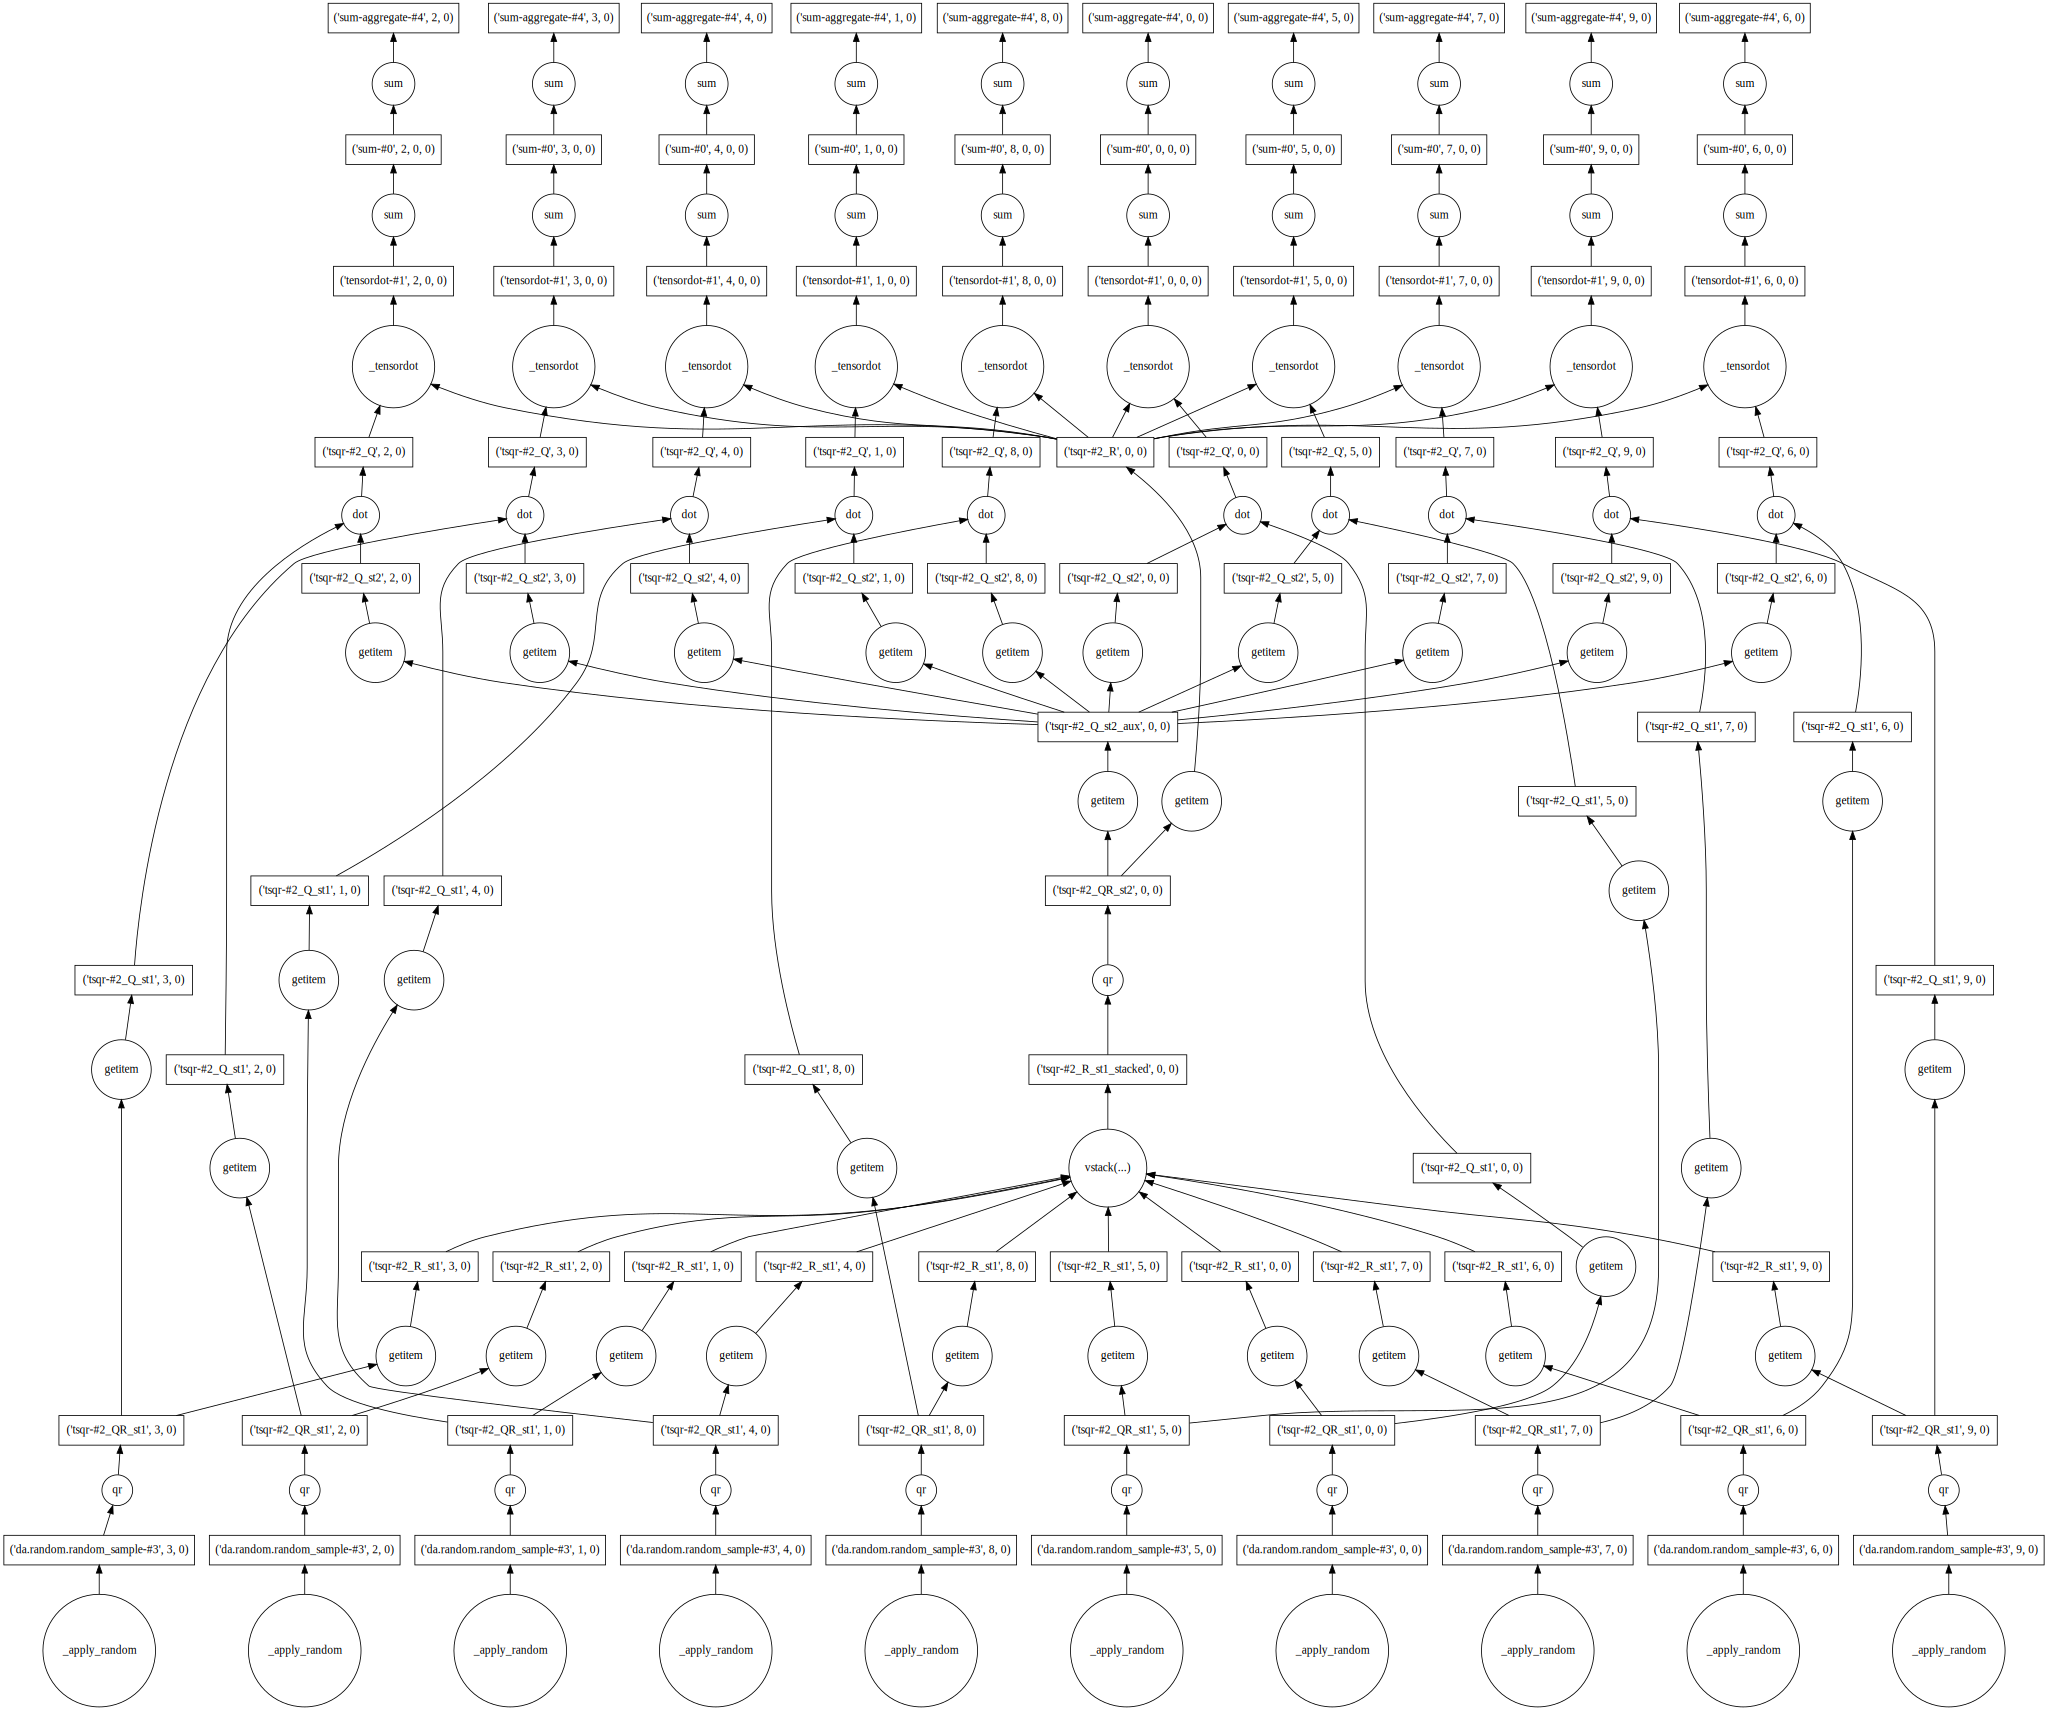

In [42]:
a2.visualize('a2.svg')

In [43]:
prof.visualize()

Figure(id='4d29600c-087c-4a40-9492-0822272f611f', ...)

In [44]:
from dask.diagnostics import visualize
visualize([prof, rprof, cprof])

Column(id='d9557843-cfd3-4524-aea8-85799b6d2431', ...)

## Distributed

In [47]:
# Single machine progress bar
from dask.diagnostics import ProgressBar

with ProgressBar():
    x.compute()

# Distributed scheduler ProgressBar

from dask.distributed import Client, progress

client = Client()  # use dask.distributed by default

x = x.persist()  # start computation in the background
progress(x)      # watch progress

x.compute()      # convert to final result when done if desired\

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  1.0s


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

## Dask Dashboard

In [48]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:55831 Dashboard: http://127.0.0.1:55832,Cluster Workers: 4 Cores: 4 Memory: 8.46 GB


In [51]:
import dask.array as da

a = da.random.random(size=(10000, 1000), chunks=(1000, 1000))
q, r = da.linalg.qr(a)
a2 = q.dot(r)

out = a2.compute()